In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import scipy

In [2]:
img_dir_l = r'Stereo_calibration_images/left-*' # images for calibration
img_dir_r = r'Stereo_calibration_images/right-*' # images for calibration

#number of blocks on the chess board in each direction
cb_vert = 6
cb_horiz = 9

num_corner_found = 0
obj_points = np.zeros((cb_vert*cb_horiz, 3), np.float32)
obj_points[:,:2] = np.mgrid[0:cb_vert, 0:cb_horiz].T.reshape(-1,2)

obj_points_3d = []
img_points_r = []
img_points_l = []

img_set_l = glob.glob(img_dir_l)
img_set_r = glob.glob(img_dir_r)

assert (len(img_set_l) != 0) and (len(img_set_r) != 0), "No images found in directory"

In [3]:
show_imgs = False

# 2 for loops for both left and right images
for calib_img_l in img_set_l:
    img_l = cv2.imread(calib_img_l)
    gray_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
    ret_l, corners_l = cv2.findChessboardCorners(gray_l, (cb_vert, cb_horiz), None)
    if ret_l:
        img_points_l.append(corners_l)
        num_corner_found += 1
        obj_points_3d.append(obj_points)

        if show_imgs:
            cv2.imshow('img_l', cv2.drawChessboardCorners(img_l, (cb_vert, cb_horiz), corners_l, ret_l))
            cv2.waitKey(100)

for calib_img_r in img_set_r:
    img_r = cv2.imread(calib_img_r)
    gray_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
    ret_r, corners_r = cv2.findChessboardCorners(gray_r, (cb_vert, cb_horiz), None)
    if ret_r:
        img_points_r.append(corners_r)
        num_corner_found += 1
        # obj_points_3d.append(obj_points)
        
        if show_imgs:
            cv2.imshow('img_r', cv2.drawChessboardCorners(img_r, (cb_vert, cb_horiz), corners_r, ret_r))
            cv2.waitKey(100)


cv2.destroyAllWindows()

assert num_corner_found != 0
print(f"Found {num_corner_found} corners")

Found 100 corners


In [4]:
# calibrate camera right and left:

left_ret, left_mtx, left_dist, left_rvecs, left_tvecs = cv2.calibrateCamera(obj_points_3d, img_points_l, gray_l.shape[::-1], None, None)

right_ret, right_mtx, right_dist, right_rvecs, right_tvecs = cv2.calibrateCamera(obj_points_3d, img_points_r, gray_r.shape[::-1], None, None)

In [5]:
# stereo calibration

retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = cv2.stereoCalibrate(obj_points_3d,
                                                                                                 img_points_l, 
                                                                                                 img_points_r, 
                                                                                                 left_mtx, 
                                                                                                 left_dist, 
                                                                                                 right_mtx, 
                                                                                                 right_dist, 
                                                                                                 gray_l.shape[::-1], 
                                                                                                 flags=cv2.CALIB_FIX_INTRINSIC)

In [6]:
# Rectification

R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(left_mtx, left_dist, right_mtx, right_dist, gray_l.shape[::-1], R, T)

mx_l, my_l = cv2.initUndistortRectifyMap(left_mtx, left_dist, R1, P1, gray_l.shape[::-1], cv2.CV_32FC1)
mx_r, my_r = cv2.initUndistortRectifyMap(right_mtx, right_dist, R2, P2, gray_r.shape[::-1], cv2.CV_32FC1)

In [7]:
# show calibration and rectification:

img_left = cv2.cvtColor(cv2.imread('Stereo_conveyor_without_occlusions/left/1585434279_805531979_Left.png'), cv2.COLOR_BGR2RGB)
img_right = cv2.cvtColor(cv2.imread('Stereo_conveyor_without_occlusions/right/1585434279_805531979_Right.png'), cv2.COLOR_BGR2RGB)

assert img_left.shape != 0 and img_right.shape != 0

img_left_h, img_left_w = img_left.shape[:2]
img_right_h, img_right_w = img_right.shape[:2]

#undistort:
img_left_dist = cv2.undistort(img_left, left_mtx, left_dist, P1, left_mtx)
img_right_dist = cv2.undistort(img_right, right_mtx, right_dist, P2, right_mtx)

# rectify:
img_left_rect = cv2.remap(img_left_dist, mx_l, my_l, cv2.INTER_LINEAR)
img_right_rect = cv2.remap(img_right_dist, mx_r, my_r, cv2.INTER_LINEAR)


In [8]:
def epi_lines(img1, img2):
    # Check if the epipolar lines are correct:

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.xfeatures2d.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    pts1 = []
    pts2 = []

    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)

    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)

    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]

    def drawlines(img1, img2, lines, pts1, pts2):
        ''' img1 - image on which we draw the epilines for the points in img2
            lines - corresponding epilines '''
        r, c = img1.shape
        img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
        for r, pt1, pt2 in zip(lines, pts1, pts2):
            color = tuple(np.random.randint(0, 255, 3).tolist())
            x0, y0 = map(int, [0, -r[2]/r[1] ])
            x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
            img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
            img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
            img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
        return img1, img2
    # Find epilines corresponding to points in right image (second image) and
    # drawing its lines on left image
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
    lines1 = lines1.reshape(-1, 3)
    img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)
    img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

    return img5, img3
        


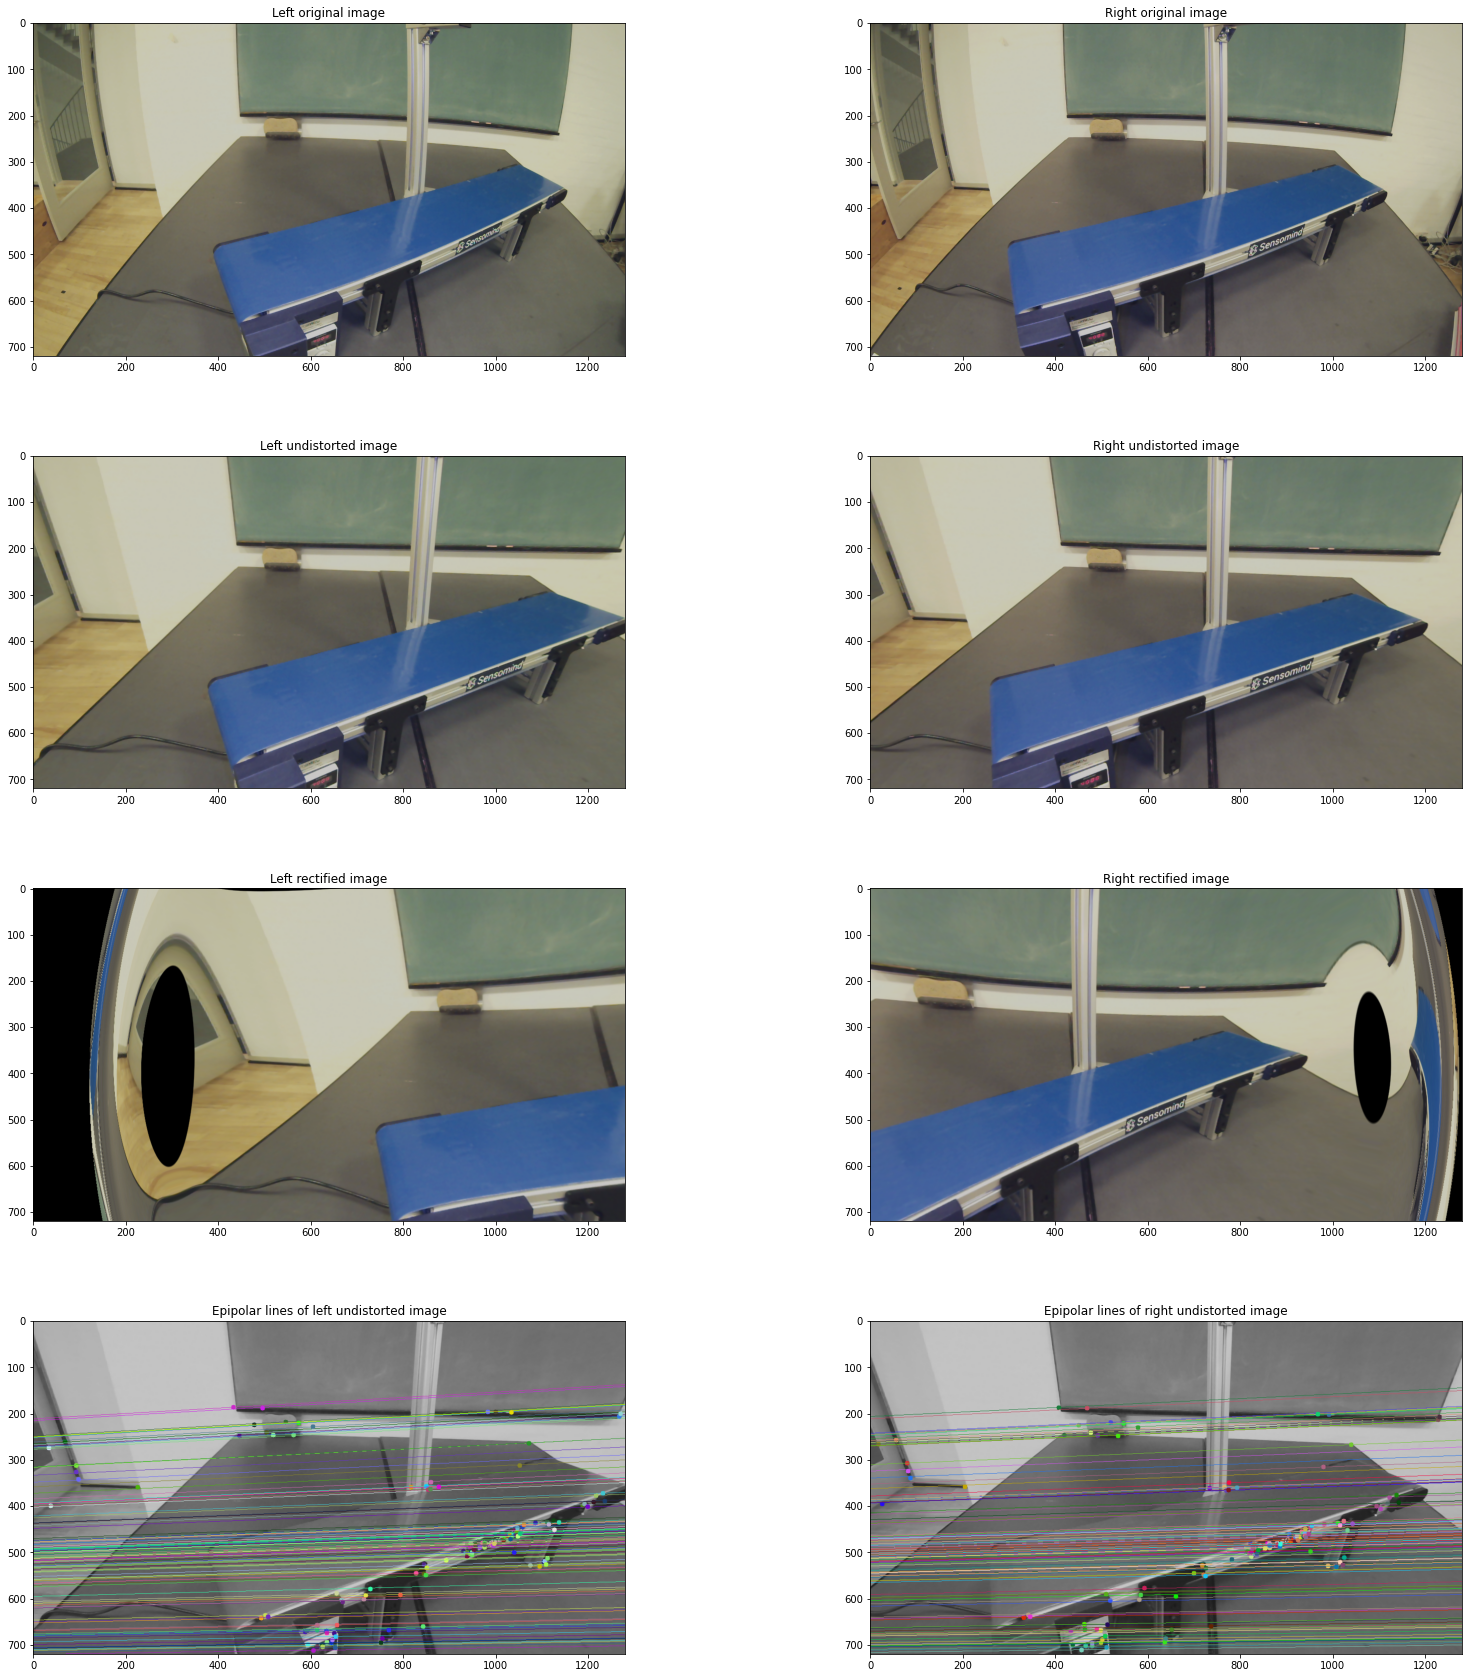

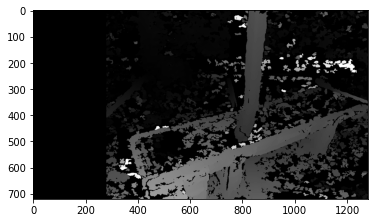

In [10]:
#show plots of images:
img_5, img_3 = epi_lines(img_left_dist, img_right_dist)

fig, axes = plt.subplots(4, 2, figsize=(30, 30))
fig.subplots_adjust(hspace=0.3, wspace=0)
axes[0, 0].imshow(img_left)
axes[0, 0].set_title('Left original image')
axes[0, 1].imshow(img_right)
axes[0, 1].set_title('Right original image')
axes[1, 0].imshow(img_left_dist)
axes[1, 0].set_title('Left undistorted image')
axes[1, 1].imshow(img_right_dist)
axes[1, 1].set_title('Right undistorted image')
axes[2, 0].imshow(img_left_rect)
axes[2, 0].set_title('Left rectified image')
axes[2, 1].imshow(img_right_rect)
axes[2, 1].set_title('Right rectified image')
axes[3, 0].imshow(img_5)
axes[3, 0].set_title('Epipolar lines of left undistorted image')
axes[3, 1].imshow(img_3)
axes[3, 1].set_title('Epipolar lines of right undistorted image')


plt.show()

#Create an SGBM image to show the disparity map:
stereo_disp = cv2.StereoSGBM_create(minDisparity=24, 
                                    numDisparities=256, 
                                    blockSize=11, 
                                    P1=500, 
                                    P2=2000, 
                                    disp12MaxDiff=1, 
                                    uniquenessRatio=10, 
                                    speckleWindowSize=100, 
                                    speckleRange=32)

dispariy_map = stereo_disp.compute(img_left_dist, img_right_dist)
plt.imshow(dispariy_map, cmap='gray')


In [20]:
dir_to_folders = r'Stereo_conveyor_with_occlusions/'

img_dir_left = dir_to_folders + 'left/*'
img_dir_right = dir_to_folders + 'right/*'

img_set_left = glob.glob(img_dir_left)
img_set_right = glob.glob(img_dir_right)

for img in img_set_left:
    name = img.strip().split('/')[-1]
    img_left = cv2.imread(img)
    img_dist = cv2.undistort(img_left, left_mtx, left_dist, P1, left_mtx)
    dirr = dir_to_folders + 'undistorted_left/'
    os.makedirs(dirr, exist_ok=True)
    cv2.imwrite(dirr + name, img_dist)

for img in img_set_right:
    name = img.strip().split('/')[-1]
    img_right = cv2.imread(img)
    img_dist = cv2.undistort(img_right, right_mtx, right_dist, P2, right_mtx)
    dirr = dir_to_folders + 'undistorted_right/'
    os.makedirs(dirr, exist_ok=True)
    cv2.imwrite(dirr + name, img_dist)